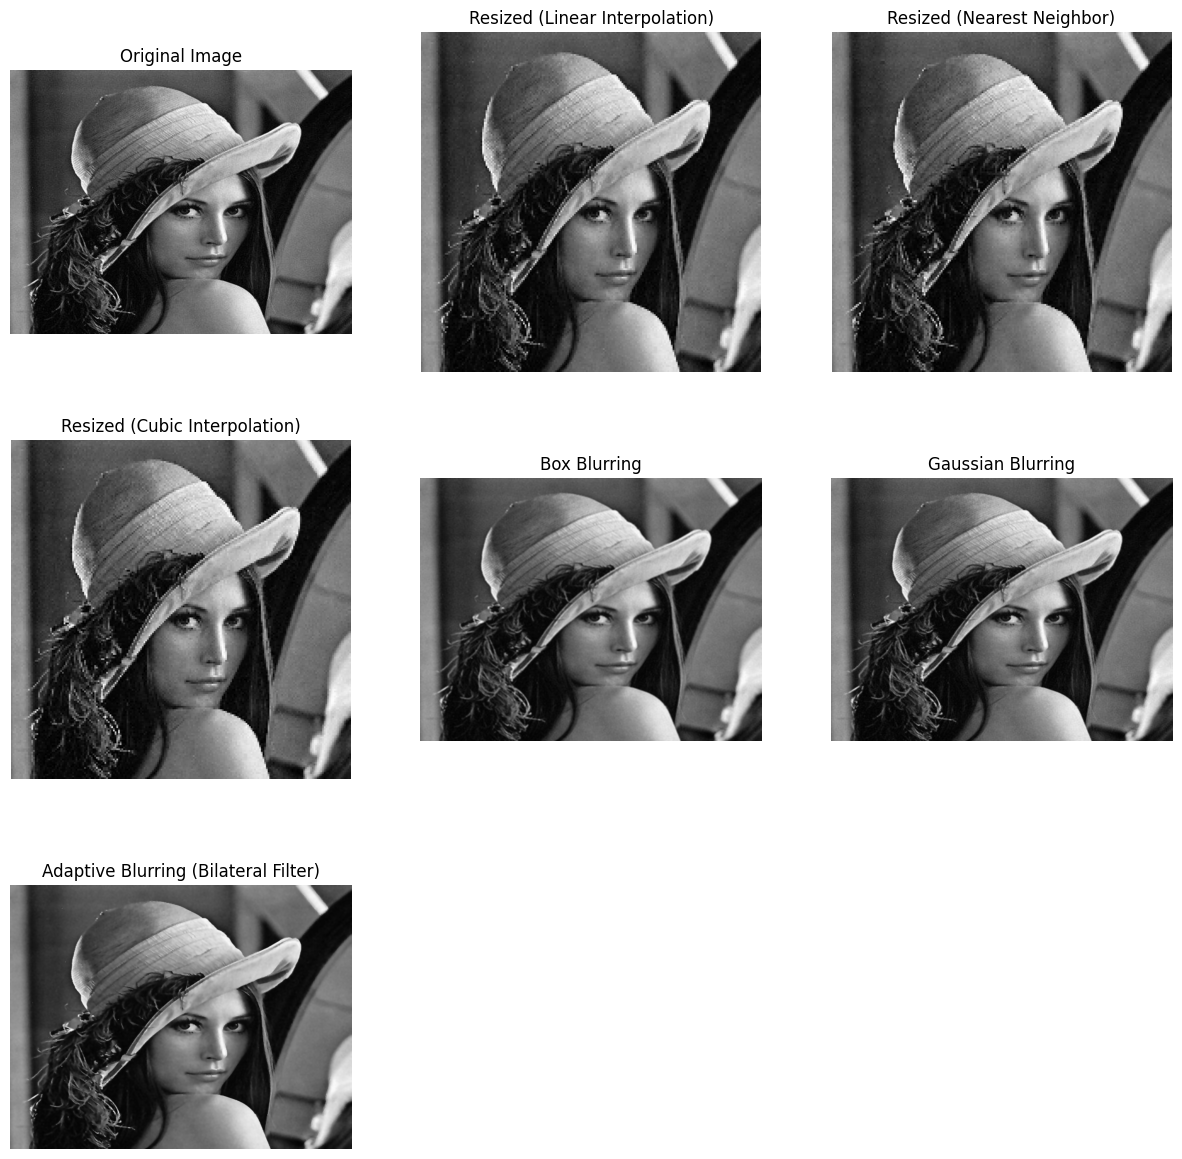

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def display_images(images, titles, cols=3):
    """Display multiple images in a grid format."""
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(15, 5 * rows))
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i + 1)
        if len(image.shape) == 2:
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
    plt.show()

# Load the image
image_path = "grayscale.png"
image = cv2.imread(image_path)

if image is None:
    print("Error: Image not found at the specified path.")
else:
    # 1.1 Image Resizing
    dimensions = (200, 200)  # Resize to 200x200 pixels

    resized_linear = cv2.resize(image, dimensions, interpolation=cv2.INTER_LINEAR)
    resized_nearest = cv2.resize(image, dimensions, interpolation=cv2.INTER_NEAREST)
    resized_cubic = cv2.resize(image, dimensions, interpolation=cv2.INTER_CUBIC)

    # 1.2 Image Blurring
    kernel_size = (5, 5)  # Kernel size for blurring

    box_blur = cv2.blur(image, kernel_size)
    gaussian_blur = cv2.GaussianBlur(image, kernel_size, 0)

    # Adaptive blurring: Using bilateral filter as an example
    adaptive_blur = cv2.bilateralFilter(image, 9, 75, 75)

    # Display the images
    display_images(
        [image, resized_linear, resized_nearest, resized_cubic, box_blur, gaussian_blur, adaptive_blur],
        [
            "Original Image",
            "Resized (Linear Interpolation)",
            "Resized (Nearest Neighbor)",
            "Resized (Cubic Interpolation)",
            "Box Blurring",
            "Gaussian Blurring",
            "Adaptive Blurring (Bilateral Filter)"
        ]
    )


In [2]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [3]:
pip install --upgrade scikit-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns

def display_images(images, titles, cols=3):
    """Display multiple images in a grid format."""
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(15, 5 * rows))
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i + 1)
        if len(image.shape) == 2:
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
    plt.show()

# Load MNIST dataset
try:
    print("Loading MNIST dataset from OpenML...")
    data = fetch_openml('mnist_784', version=1, as_frame=False)
    X, y = data.data, data.target.astype(int)
    X /= 255.0
except Exception as e:
    print("Failed to load MNIST from OpenML. Falling back to Keras dataset.")
    from tensorflow.keras.datasets import mnist
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
    X_test = X_test.reshape(X_test.shape[0], -1) / 255.0
    X, y = np.vstack((X_train, X_test)), np.hstack((y_train, y_test))


# Normalize the data
X /= 255.0

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define algorithms
models = {
    "Naive Bayes": GaussianNB(),
    "Support Vector Machine": SVC(probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(128,), max_iter=200, random_state=42)
}

# Perform K-Fold Cross Validation and evaluate models
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    # Train model
    model.fit(X_train, y_train)

    # K-Fold Cross Validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')

    # Predict on test set
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    # ROC and AUC (only for models with probability outputs)
    if y_proba is not None and len(np.unique(y_test)) == 2:
        fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label=1)
        roc_auc = auc(fpr, tpr)
    else:
        fpr, tpr, roc_auc = None, None, None

    # Store results
    results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Confusion Matrix": cm,
        "ROC": (fpr, tpr) if fpr is not None else None,
        "AUC": roc_auc
    }

    print(f"{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if roc_auc is not None:
        print(f"AUC: {roc_auc:.4f}")
    print("\n")

# Plot confusion matrices
for model_name, metrics in results.items():
    cm = metrics["Confusion Matrix"]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Plot ROC curves for models with ROC data
plt.figure(figsize=(10, 8))
for model_name, metrics in results.items():
    if metrics["ROC"] is not None:
        fpr, tpr = metrics["ROC"]
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {metrics['AUC']:.4f})")

plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

Loading MNIST dataset from OpenML...
Failed to load MNIST from OpenML. Falling back to Keras dataset.
Evaluating Naive Bayes...
Naive Bayes Results:
Accuracy: 0.5539
Precision: 0.6846
Recall: 0.5539
F1-Score: 0.5167


Evaluating Support Vector Machine...
